In [1]:
# Installation of the requirements
#!python -m pip install -r requirements.txt

In [1]:
'''
(C) Renata Wong 2023

Qiskit code for testing fidelity of derandomised classical shadow on the ground state energy of molecules. 
This notebook implements an optimization: since the derandomized Hamiltonian may contan very few terms,
instead of generating a quantum circuit for each and measuring once, we generate a single circuit and specify 
a shot number that matches the number of occurrences of a derandomized operator. This speeds up the computation 
significantly. 

Procedure:
1. Derandomize the molecule-in-question's Hamiltonian.
2. Choose a variational ansatz with initial parameters selected at random.
3. Apply the derandomized Hamiltonian as basis change operators to the ansatz.
4. Measure the ansatz in the Pauli Z basis and store the results as a shadow.
5. Obtain the expectation value of the molecular Hamiltonian from the shadow.
6. Optimize for minimum Hamiltonian expectation value. 
7. Feed the calculated angles/parameters back to the ansatz.
8. Repeat steps 3-7 till the optimization is completed. 
9. Output the minimized expectation value of the molecular Hamiltonian and the mean-square-root-error. 

Note: Below we perform calculations on the molecular Hamiltonian of H_2.
To perform calculations on other molecules, you will need to specify their geometry, charge and spin 
to replace the values in the driver. 
'''

import numpy as np
import matplotlib.pyplot as plt
import time

from functools import partial

from qiskit.circuit.library import EfficientSU2

from qiskit_aer import QasmSimulator
from qiskit import QuantumCircuit, execute

from qiskit.algorithms.optimizers import SLSQP, COBYLA

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from collections import Counter

from qiskit_nature.second_q.mappers import BravyiKitaevMapper, QubitConverter
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.opflow import I, StateFn, CircuitStateFn

from predicting_quantum_properties.data_acquisition_shadow import derandomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp





# SPECIFY THE NUMBER OF EXPERIMENTS YOU WANT TO RUN
num_experiments = 10

# SPECIFY THE EXPECTED GROUND STATE ENERGY FOR THE MOLECULE OF INTEREST
EXPECTED_EIGENVALUE = -1.86



# SPECIFY THE GEOMETRY OF THE MOLECULE IN QUESTION
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
hamiltonian = problem.hamiltonian

# The electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# Solving the electronic structure problem = determine the ground state energy of the molecule
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
mapper = BravyiKitaevMapper()
bkenc_hamiltonian = mapper.map(second_q_op)

print(bkenc_hamiltonian)

-0.8105479805373234 * IIII
+ 0.1721839326191557 * IIIZ
- 0.2257534922240249 * IIZZ
+ 0.1721839326191554 * IZII
- 0.22575349222402488 * ZZZI
+ 0.1209126326177664 * IIZI
+ 0.1689275387008791 * IZIZ
+ 0.04523279994605785 * ZXIX
- 0.04523279994605785 * IXZX
- 0.04523279994605785 * ZXZX
+ 0.04523279994605785 * IXIX
+ 0.1661454325638242 * ZZZZ
+ 0.16614543256382422 * IZZZ
+ 0.1746434306830045 * ZZIZ
+ 0.1209126326177664 * ZIZI


/home/renata/.local/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
/home/renata/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


In [2]:
'''
Format Hamiltonian terms and coefficients as required by the package predicting-quantum-properties
'''

hamiltonian_terms = []
weights = []

for observable in bkenc_hamiltonian:
    
    observable_str = str(observable)
    observable_str_clean = observable_str.strip()  # removes white spaces
    pauli_str_list = observable_str_clean.split('*')
    tuple_list = []
    
    for op_index, pauli_op in enumerate(pauli_str_list[1]):
        if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
            tuple_list.append((pauli_op, op_index-1))
    if len(tuple_list) > 0:
        hamiltonian_terms.append(tuple_list)
        weights.append(float(pauli_str_list[0].strip()))

system_size = len(hamiltonian_terms[0])

print('Hamiltonian terms:\n', hamiltonian_terms)
print('Weights:\n', weights)







'''
Reformatting the Hamiltonian for use in estimate_exp(): removing all entries with Pauli I. 
'''

hamiltonian_terms_XYZ = []

for term in hamiltonian_terms:
    term_XYZ = []
    for pauli in term:
        if pauli[0] != 'I':
            term_XYZ.append(pauli)
    hamiltonian_terms_XYZ.append(term_XYZ)         
    
print('Hamiltonian terms without Pauli-I:\n', hamiltonian_terms_XYZ)

Hamiltonian terms:
 [[('I', 0), ('I', 1), ('I', 2), ('I', 3)], [('I', 0), ('I', 1), ('I', 2), ('Z', 3)], [('I', 0), ('I', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('I', 2), ('I', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('I', 3)], [('I', 0), ('I', 1), ('Z', 2), ('I', 3)], [('I', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('X', 1), ('I', 2), ('X', 3)], [('I', 0), ('X', 1), ('Z', 2), ('X', 3)], [('Z', 0), ('X', 1), ('Z', 2), ('X', 3)], [('I', 0), ('X', 1), ('I', 2), ('X', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('Z', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('I', 1), ('Z', 2), ('I', 3)]]
Weights:
 [-0.8105479805373234, 0.1721839326191557, -0.2257534922240249, 0.1721839326191554, -0.22575349222402488, 0.1209126326177664, 0.1689275387008791, 0.04523279994605785, -0.04523279994605785, -0.04523279994605785, 0.04523279994605785, 0.1661454325638242, 0.16614543256382422, 0.1746434306830045, 0.1209126326177664]
Hamiltonian terms without P

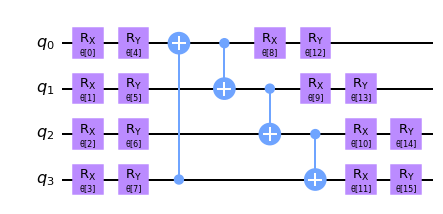

In [3]:
'''
Choose a variational ansatz.
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 1   
ansatz = EfficientSU2(system_size, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=False)  
    
ansatz.decompose().draw('mpl')

In [20]:
'''
Generate derandomized Hamiltonian
'''

num_obs_evals = 67    

derandomized_hamiltonian = derandomized_classical_shadow(hamiltonian_terms, 
                                                                num_obs_evals, system_size, weight=weights)

tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
counts = Counter(tuples)
print('Derandomised Hamitlonian:', counts)

Derandomised Hamitlonian: Counter({('Z', 'X', 'X', 'X'): 1005})


In [4]:
'''
Define the cost function
'''


backend = QasmSimulator(method='statevector', shots=1)


# Create circuit with just the randomised basis change operators
def rand_meas_circuit(pauli_op):
    rand_meas = QuantumCircuit(ansatz.num_qubits)
    for idx, op in enumerate(pauli_op):
        if op == 'X':
            rand_meas.x(idx)
        elif op == 'Y':
            rand_meas.y(idx)
        elif op == 'Z':
            rand_meas.z(idx)
    return rand_meas


def objective_function(params):
    
    
    # Assign parameters to the ansatz and simulate it
    # Generate circuits to measure random Paulis, one circuit for each Pauli
    
    # Putting repeated operators in derandomized_hamiltonian together and executing one single circuit 
    # as many times as the operator repetitions. 
    
    # convert the inner lists to tuples and count duplicates
    pauli_op_dict = Counter(tuple(x) for x in derandomized_hamiltonian)
    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        qc = ansatz.bind_parameters(params)
        qc.compose(rand_meas_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()
        
        
        # store the shadow in the form [[(Z,1),(Z,-1)...], [(Y,-1),(X,-1),...]] where inner list = snapshot
        # Because measurement output in Qiskit gives us states and not eigenvalues, we need to convert 0->1 and 1->-1
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values
                output_str = list(count)
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                shadow.append(snapshot)
    
    
    # Now, we want to get the expectation values for the Hamiltonian from the shadow using the function
    # estimate_exp(full_measurement, one_observable)
    # where full_measurement = shadow and one_observable is any term in the Hamiltonian with I observable excluded.
    # cost = the total expectation value of the Hamiltonian
    # NOTE: We need to check for match_count value since it may happen that it is equal to 0. 
    # Such experiments need to be excluded. 
    # The problem is due to the derandomization algorithm not always producing Paulis that 'hit' the Hamiltonian terms.
    # NOTE: For term = [] we have that sum_product = match_count = len(shadow)
    
    cost = 0.0

    for term, weight in zip(hamiltonian_terms_XYZ, weights):
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = sum_product / match_count
            cost = cost + (weight * exp_val)     
        
    cost_history.append(cost)

        
    return cost


GROUND STATE ENERGY FOUND =  -0.8569959900341708
GROUND STATE ENERGY FOUND =  -0.8614967661482064
GROUND STATE ENERGY FOUND =  -0.8937223231247013
GROUND STATE ENERGY FOUND =  -0.853485384665223
GROUND STATE ENERGY FOUND =  -0.8990332389392633
GROUND STATE ENERGY FOUND =  -0.8773394980696118
GROUND STATE ENERGY FOUND =  -0.8550156485439951
GROUND STATE ENERGY FOUND =  -0.8585262539129429
GROUND STATE ENERGY FOUND =  -0.8839106311961038
GROUND STATE ENERGY FOUND =  -0.8561858503336445
Execution time =  00:00:50
Average root-mean-squared error for derandomized classical shadow: 0.9905657607338937


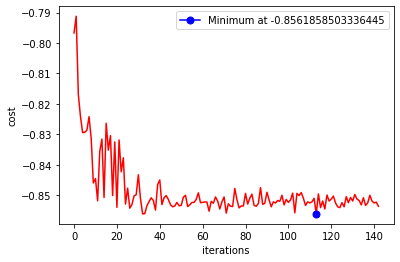

In [22]:
'''
Classical optimisation step
'''

# Counter for the execution time
start_time = time.time()


# Classical optimizer
optimizer = COBYLA(maxiter=1000)  #SLSQP(maxiter=500)   

# Collect the expectation value from each experiment
expectation_values = []


for iteration in range(num_experiments):
    cost_history = []
    params = np.random.rand(ansatz.num_parameters)
    result = optimizer.minimize(fun=objective_function, x0=params)
    expectation_values.append(min(cost_history))    
    print("GROUND STATE ENERGY FOUND = ", min(cost_history))
    
    if iteration == num_experiments-1:
        
        num_points = len(cost_history)
        min_energy = min(cost_history)
        min_ener_idx = cost_history.index(min_energy)
        minimum_str = str(min_energy)

        plt.plot([i for i in range(num_points)], [cost_history[i] for i in range(num_points)], 'r')
        plt.plot(min_ener_idx, min_energy, 'b', marker="o", markersize=7, label='Minimum at '+ minimum_str)
        plt.xlabel('iterations')
        plt.ylabel('cost')
        plt.legend(loc=1)
    
    
elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


'''
Calculate the error.
'''
rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                       for i in range(num_experiments)])/num_experiments)
print(f"Average root-mean-squared error for derandomized classical shadow: {rmse_derandomised_cs}")

GROUND STATE ENERGY FOUND =  -1.6992208451076578
GROUND STATE ENERGY FOUND =  -1.6893817632437058
GROUND STATE ENERGY FOUND =  -1.666423905561152
GROUND STATE ENERGY FOUND =  -1.6762629874251036
GROUND STATE ENERGY FOUND =  -1.6992208451076578
GROUND STATE ENERGY FOUND =  -1.728738090699513
GROUND STATE ENERGY FOUND =  -1.7025005390623085
GROUND STATE ENERGY FOUND =  -1.71233962092626
GROUND STATE ENERGY FOUND =  -1.6959411511530071
GROUND STATE ENERGY FOUND =  -1.6565848236972
Execution time =  00:01:15
Average root-mean-squared error for derandomized classical shadow: 0.168574567046793


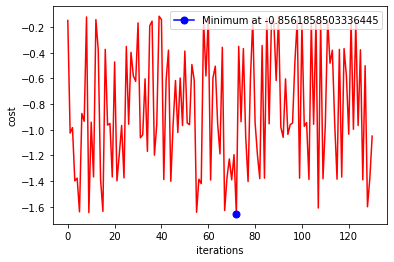

In [23]:
'''
Experiments with num_evals = 7. 
We test if more heterogeneous derandomized Hamiltonian performs better than more homogeneous one.
The results suggest that heterogeneity plays an important role in the performance:
we were able to obtain much better expectation values for just 105 derandomized operators than for 1005. 
'''

num_obs_evals = 7    

derandomized_hamiltonian = derandomized_classical_shadow(hamiltonian_terms, 
                                                                num_obs_evals, system_size, weight=weights)

start_time = time.time()
optimizer = COBYLA(maxiter=1000)   
expectation_values = []
num_experiments = 10

for iteration in range(num_experiments):
    cost_history = []
    params = np.random.rand(ansatz.num_parameters)
    result = optimizer.minimize(fun=objective_function, x0=params)
    expectation_values.append(min(cost_history))    
    print("GROUND STATE ENERGY FOUND = ", min(cost_history))
    
    if iteration == num_experiments-1:
        
        num_points = len(cost_history)
        
        min_energy = min(cost_history)
        min_energy_idx = cost_history.index(min_energy)

        plt.plot([i for i in range(num_points)], [cost_history[i] for i in range(num_points)], 'r')
        plt.plot(min_energy_idx, min_energy, 'b', marker="o", markersize=7, label='Minimum at '+ minimum_str)
        plt.xlabel('iterations')
        plt.ylabel('cost')
        plt.legend(loc=1)
    
    
    
elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                       for i in range(num_experiments)])/num_experiments)
print(f"Average root-mean-squared error for derandomized classical shadow: {rmse_derandomised_cs}")


GROUND STATE ENERGY FOUND =  -0.8015464283092552
GROUND STATE ENERGY FOUND =  -0.7820130599743407
GROUND STATE ENERGY FOUND =  -0.7923648450366225
GROUND STATE ENERGY FOUND =  -0.797855791895746
GROUND STATE ENERGY FOUND =  -0.8035267697994308
GROUND STATE ENERGY FOUND =  -0.7946152330936402
GROUND STATE ENERGY FOUND =  -0.8094677942699577
GROUND STATE ENERGY FOUND =  -0.8075774683020629
GROUND STATE ENERGY FOUND =  -0.8066773130792557
GROUND STATE ENERGY FOUND =  -0.7977657763734652
Execution time =  00:01:36
Average root-mean-squared error for derandomized classical shadow: 1.060688298513156


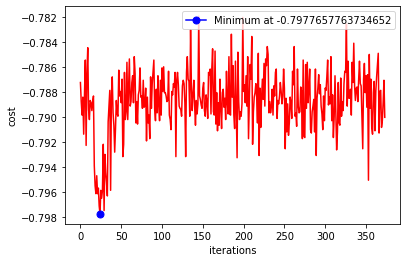

In [10]:
'''
Testing another optimizer: L-BFGS-B
'''

import scipy


start_time = time.time() 
expectation_values = []

num_obs_evals = 67    

derandomized_hamiltonian = derandomized_classical_shadow(hamiltonian_terms, num_obs_evals, system_size, weight=weights)

num_experiments = 10

for iteration in range(num_experiments):
    cost_history = []
    params = np.random.rand(ansatz.num_parameters)
    result = scipy.optimize.minimize(fun=objective_function, x0=params, method='L-BFGS-B')
    expectation_values.append(min(cost_history))    
    print("GROUND STATE ENERGY FOUND = ", min(cost_history))
    
    if iteration == num_experiments-1:
        
        num_points = len(cost_history)
        min_energy = min(cost_history)
        min_ener_idx = cost_history.index(min_energy)
        minimum_str = str(min_energy)

        plt.plot([i for i in range(num_points)], [cost_history[i] for i in range(num_points)], 'r')
        plt.plot(min_ener_idx, min_energy, 'b', marker="o", markersize=7, label='Minimum at '+ minimum_str)
        plt.xlabel('iterations')
        plt.ylabel('cost')
        plt.legend(loc=1)
    
    
elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


'''
Calculate the error.
'''
rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                       for i in range(num_experiments)])/num_experiments)
print(f"Average root-mean-squared error for derandomized classical shadow: {rmse_derandomised_cs}")

In [18]:
'''
Experiments with varying num_obs_evals. 
We test if more heterogeneous derandomized Hamiltonian performs better than more homogeneous one.
The results suggest that heterogeneity plays an important role in the performance:
we were able to obtain much better expectation values for just 105 derandomized operators than for 1005. 
'''

# Store operators and errors for comparison
op_err = []

for num_evals in range(6, 101):    
    
    derandomized_hamiltonian = derandomized_classical_shadow(hamiltonian_terms, 
                                                                    num_evals, system_size, weight=weights)
    
    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    print(f'EVALUATIONS PER OBSERVABLE =', num_evals, 'DERANDOMISED OPERATORS =', counts)
    
    start_time = time.time()
    optimizer = COBYLA(maxiter=1000)   
    expectation_values = []
    num_experiments = 10

    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=objective_function, x0=params)
        expectation_values.append(min(cost_history))    
        print("GROUND STATE ENERGY FOUND = ", min(cost_history))



    elapsed_time = time.time() - start_time
    print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)
    print(f"Average root-mean-squared error for derandomized classical shadow: {rmse_derandomised_cs}")
    print('\n')
    
    op_err.append((counts, rmse_derandomised_cs))
    
    


EVALUATIONS PER OBSERVABLE = 6 DERANDOMISED OPERATORS = Counter({('Z', 'Z', 'X', 'X'): 90})
GROUND STATE ENERGY FOUND =  -0.8488110766749134
GROUND STATE ENERGY FOUND =  -0.8488110766749134
GROUND STATE ENERGY FOUND =  -0.8488110766749134
GROUND STATE ENERGY FOUND =  -0.8449847670611544
GROUND STATE ENERGY FOUND =  -0.8641163151299495
GROUND STATE ENERGY FOUND =  -0.8641163151299495
GROUND STATE ENERGY FOUND =  -0.8564636959024314
GROUND STATE ENERGY FOUND =  -0.8526373862886725
GROUND STATE ENERGY FOUND =  -0.8488110766749134
GROUND STATE ENERGY FOUND =  -0.8602900055161905
Execution time =  00:00:21
Average root-mean-squared error for derandomized classical shadow: 1.006236618669582


EVALUATIONS PER OBSERVABLE = 7 DERANDOMISED OPERATORS = Counter({('Z', 'Z', 'X', 'X'): 104, ('Z', 'Z', 'Z', 'Z'): 1})
GROUND STATE ENERGY FOUND =  -1.4268831586450783
GROUND STATE ENERGY FOUND =  -1.4465613223729819
GROUND STATE ENERGY FOUND =  -1.6795426813797543
GROUND STATE ENERGY FOUND =  -1.7057802

GROUND STATE ENERGY FOUND =  -1.5338241410452174
GROUND STATE ENERGY FOUND =  -1.429378506258414
GROUND STATE ENERGY FOUND =  -1.6911180718079326
GROUND STATE ENERGY FOUND =  -1.6789639118583455
GROUND STATE ENERGY FOUND =  -1.572987545327221
GROUND STATE ENERGY FOUND =  -1.4415326662080012
Execution time =  00:00:44
Average root-mean-squared error for derandomized classical shadow: 0.29531789058887287


EVALUATIONS PER OBSERVABLE = 18 DERANDOMISED OPERATORS = Counter({('Z', 'Z', 'X', 'X'): 268, ('Z', 'Z', 'Z', 'Z'): 2})
GROUND STATE ENERGY FOUND =  -1.5637341281907065
GROUND STATE ENERGY FOUND =  -1.4027386805153619
GROUND STATE ENERGY FOUND =  -1.339832763362843
GROUND STATE ENERGY FOUND =  -1.5453780955651952
GROUND STATE ENERGY FOUND =  -1.563234207096071
GROUND STATE ENERGY FOUND =  -1.6533051297425494
GROUND STATE ENERGY FOUND =  -1.5458780166598312
GROUND STATE ENERGY FOUND =  -1.3821222187114772
GROUND STATE ENERGY FOUND =  -1.469336974835833
GROUND STATE ENERGY FOUND =  -1.418

GROUND STATE ENERGY FOUND =  -0.8550528963463182
GROUND STATE ENERGY FOUND =  -0.8531811942795848
GROUND STATE ENERGY FOUND =  -0.8550528963463182
GROUND STATE ENERGY FOUND =  -0.8538050949684959
GROUND STATE ENERGY FOUND =  -0.8727300825321339
GROUND STATE ENERGY FOUND =  -0.8652432742652002
GROUND STATE ENERGY FOUND =  -0.8486059225609031
GROUND STATE ENERGY FOUND =  -0.8999737459479206
GROUND STATE ENERGY FOUND =  -0.8652432742652002
GROUND STATE ENERGY FOUND =  -0.8592122342723925
Execution time =  00:00:26
Average root-mean-squared error for derandomized classical shadow: 0.9972902272584416


EVALUATIONS PER OBSERVABLE = 30 DERANDOMISED OPERATORS = Counter({('Z', 'X', 'X', 'X'): 450})
GROUND STATE ENERGY FOUND =  -0.861610785809762
GROUND STATE ENERGY FOUND =  -0.8567859538155158
GROUND STATE ENERGY FOUND =  -0.8579921618140774
GROUND STATE ENERGY FOUND =  -0.8579921618140774
GROUND STATE ENERGY FOUND =  -0.8593994044790658
GROUND STATE ENERGY FOUND =  -0.8678428604689966
GROUND S

GROUND STATE ENERGY FOUND =  -0.8755655336305187
GROUND STATE ENERGY FOUND =  -0.8521768663413376
GROUND STATE ENERGY FOUND =  -0.8574724136520956
GROUND STATE ENERGY FOUND =  -0.8986600038468799
GROUND STATE ENERGY FOUND =  -0.8596788916982447
GROUND STATE ENERGY FOUND =  -0.8973361170191904
GROUND STATE ENERGY FOUND =  -0.8523239648777475
GROUND STATE ENERGY FOUND =  -0.851000078050058
GROUND STATE ENERGY FOUND =  -0.8596788916982447
GROUND STATE ENERGY FOUND =  -0.8421741658654615
Execution time =  00:00:33
Average root-mean-squared error for derandomized classical shadow: 0.99556629567378


EVALUATIONS PER OBSERVABLE = 42 DERANDOMISED OPERATORS = Counter({('Z', 'X', 'X', 'X'): 630})
GROUND STATE ENERGY FOUND =  -0.8595142814313097
GROUND STATE ENERGY FOUND =  -0.8916798280596175
GROUND STATE ENERGY FOUND =  -0.8557807804833812
GROUND STATE ENERGY FOUND =  -0.8566423576252109
GROUND STATE ENERGY FOUND =  -0.8514728947742328
GROUND STATE ENERGY FOUND =  -0.8577911271476505
GROUND STA

GROUND STATE ENERGY FOUND =  -0.8467342204941697
GROUND STATE ENERGY FOUND =  -0.8932756423254593
GROUND STATE ENERGY FOUND =  -0.8499204303016907
GROUND STATE ENERGY FOUND =  -0.8999894415627359
GROUND STATE ENERGY FOUND =  -0.8572031955760245
GROUND STATE ENERGY FOUND =  -0.8551549178426182
GROUND STATE ENERGY FOUND =  -0.8560652635019099
GROUND STATE ENERGY FOUND =  -0.8583411276501391
GROUND STATE ENERGY FOUND =  -0.8985101298663868
GROUND STATE ENERGY FOUND =  -0.8541307789759149
Execution time =  00:00:35
Average root-mean-squared error for derandomized classical shadow: 0.9932724054884647


EVALUATIONS PER OBSERVABLE = 54 DERANDOMISED OPERATORS = Counter({('Z', 'X', 'X', 'X'): 810})
GROUND STATE ENERGY FOUND =  -0.8978863745072424
GROUND STATE ENERGY FOUND =  -0.8545522352996611
GROUND STATE ENERGY FOUND =  -0.8659441997305202
GROUND STATE ENERGY FOUND =  -0.8547756071512466
GROUND STATE ENERGY FOUND =  -0.8570093256671013
GROUND STATE ENERGY FOUND =  -0.9003434648746826
GROUND 

EVALUATIONS PER OBSERVABLE = 65 DERANDOMISED OPERATORS = Counter({('Z', 'X', 'X', 'X'): 975})
GROUND STATE ENERGY FOUND =  -0.8574973072505649
GROUND STATE ENERGY FOUND =  -0.8621365687834939
GROUND STATE ENERGY FOUND =  -0.8565694549439792
GROUND STATE ENERGY FOUND =  -0.9001785133535118
GROUND STATE ENERGY FOUND =  -0.8559199583293691
GROUND STATE ENERGY FOUND =  -0.8548065355614661
GROUND STATE ENERGY FOUND =  -0.8574973072505649
GROUND STATE ENERGY FOUND =  -0.8544353946388319
GROUND STATE ENERGY FOUND =  -0.8863535139853834
GROUND STATE ENERGY FOUND =  -0.8970238155111201
Execution time =  00:00:34
Average root-mean-squared error for derandomized classical shadow: 0.9919146278025336


EVALUATIONS PER OBSERVABLE = 66 DERANDOMISED OPERATORS = Counter({('Z', 'X', 'X', 'X'): 990})
GROUND STATE ENERGY FOUND =  -0.8479221526139651
GROUND STATE ENERGY FOUND =  -0.8626342350206627
GROUND STATE ENERGY FOUND =  -0.8519428459425036
GROUND STATE ENERGY FOUND =  -0.8581566447229722
GROUND STAT

GROUND STATE ENERGY FOUND =  -0.8557807804833812
Execution time =  00:00:33
Average root-mean-squared error for derandomized classical shadow: 0.9946889605747836


EVALUATIONS PER OBSERVABLE = 77 DERANDOMISED OPERATORS = Counter({('Z', 'X', 'X', 'X'): 1155})
GROUND STATE ENERGY FOUND =  -0.854331764381213
GROUND STATE ENERGY FOUND =  -0.8546450651600602
GROUND STATE ENERGY FOUND =  -0.8582480241168026
GROUND STATE ENERGY FOUND =  -0.8567598454172786
GROUND STATE ENERGY FOUND =  -0.8930244105688366
GROUND STATE ENERGY FOUND =  -0.8533135368499599
GROUND STATE ENERGY FOUND =  -0.8584829997009379
GROUND STATE ENERGY FOUND =  -0.8522953093187067
GROUND STATE ENERGY FOUND =  -0.855115016328331
GROUND STATE ENERGY FOUND =  -0.899917027703474
Execution time =  00:00:34
Average root-mean-squared error for derandomized classical shadow: 0.9965250919745883


EVALUATIONS PER OBSERVABLE = 78 DERANDOMISED OPERATORS = Counter({('Z', 'X', 'X', 'X'): 1170})
GROUND STATE ENERGY FOUND =  -0.856090064585

GROUND STATE ENERGY FOUND =  -0.8483105150377444
GROUND STATE ENERGY FOUND =  -0.8984778022506449
GROUND STATE ENERGY FOUND =  -0.8539303477583152
GROUND STATE ENERGY FOUND =  -0.8988890095228818
Execution time =  00:00:36
Average root-mean-squared error for derandomized classical shadow: 0.9918754949224892


EVALUATIONS PER OBSERVABLE = 89 DERANDOMISED OPERATORS = Counter({('Z', 'X', 'X', 'X'): 1335})
GROUND STATE ENERGY FOUND =  -0.8572377171108572
GROUND STATE ENERGY FOUND =  -0.9009458159351379
GROUND STATE ENERGY FOUND =  -0.8572377171108572
GROUND STATE ENERGY FOUND =  -0.8702485000166896
GROUND STATE ENERGY FOUND =  -0.85459490183311
GROUND STATE ENERGY FOUND =  -0.9007425224522343
GROUND STATE ENERGY FOUND =  -0.8575087750880621
GROUND STATE ENERGY FOUND =  -0.8870540946033897
GROUND STATE ENERGY FOUND =  -0.8523586735211701
GROUND STATE ENERGY FOUND =  -0.85683113014505
Execution time =  00:00:36
Average root-mean-squared error for derandomized classical shadow: 0.990695356123

GROUND STATE ENERGY FOUND =  -0.8559014012832373
GROUND STATE ENERGY FOUND =  -0.8974552668336825
GROUND STATE ENERGY FOUND =  -0.8535492956860423
GROUND STATE ENERGY FOUND =  -0.900953270029511
GROUND STATE ENERGY FOUND =  -0.8586153692800008
GROUND STATE ENERGY FOUND =  -0.8562029532828778
GROUND STATE ENERGY FOUND =  -0.8999279932307337
Execution time =  00:00:40
Average root-mean-squared error for derandomized classical shadow: 0.9823192291426316




In [19]:
for op, err in op_err:
    print('OPERATOR:', op, 'ERROR:', err)

OPERATOR: Counter({('Z', 'Z', 'X', 'X'): 90}) ERROR: 1.006236618669582
OPERATOR: Counter({('Z', 'Z', 'X', 'X'): 104, ('Z', 'Z', 'Z', 'Z'): 1}) ERROR: 0.2411464130439959
OPERATOR: Counter({('Z', 'Z', 'X', 'X'): 119, ('Z', 'Z', 'Z', 'Z'): 1}) ERROR: 0.18148738479286314
OPERATOR: Counter({('Z', 'Z', 'X', 'X'): 134, ('Z', 'Z', 'Z', 'Z'): 1}) ERROR: 0.1875621523461598
OPERATOR: Counter({('Z', 'Z', 'X', 'X'): 149, ('Z', 'Z', 'Z', 'Z'): 1}) ERROR: 0.19653175728448846
OPERATOR: Counter({('Z', 'Z', 'X', 'X'): 164, ('Z', 'Z', 'Z', 'Z'): 1}) ERROR: 0.2770925235217396
OPERATOR: Counter({('Z', 'Z', 'X', 'X'): 179, ('Z', 'Z', 'Z', 'Z'): 1}) ERROR: 0.2175848062223378
OPERATOR: Counter({('Z', 'Z', 'X', 'X'): 193, ('Z', 'Z', 'Z', 'Z'): 2}) ERROR: 0.3043671445511125
OPERATOR: Counter({('Z', 'Z', 'X', 'X'): 208, ('Z', 'Z', 'Z', 'Z'): 2}) ERROR: 0.315307813343094
OPERATOR: Counter({('Z', 'Z', 'X', 'X'): 223, ('Z', 'Z', 'Z', 'Z'): 2}) ERROR: 0.31075744190018456
OPERATOR: Counter({('Z', 'Z', 'X', 'X'): 238,

ZXZX: 1, ZZZZ: 999, AVERAGE ERROR: 0.5642202665171249
ZXZX: 2, ZZZZ: 998, AVERAGE ERROR: 0.5913924932676247
ZXZX: 3, ZZZZ: 997, AVERAGE ERROR: 0.5933385216462763
ZXZX: 4, ZZZZ: 996, AVERAGE ERROR: 0.7436508502497616
ZXZX: 5, ZZZZ: 995, AVERAGE ERROR: 0.6744607914493679
ZXZX: 6, ZZZZ: 994, AVERAGE ERROR: 0.7372569502296505
ZXZX: 7, ZZZZ: 993, AVERAGE ERROR: 0.7702332272496927
ZXZX: 8, ZZZZ: 992, AVERAGE ERROR: 0.8271016736931494
ZXZX: 9, ZZZZ: 991, AVERAGE ERROR: 0.5389528411663183
ZXZX: 10, ZZZZ: 990, AVERAGE ERROR: 0.6802902339023915
ZXZX: 11, ZZZZ: 989, AVERAGE ERROR: 0.754259196356626
ZXZX: 12, ZZZZ: 988, AVERAGE ERROR: 0.7523444374593796
ZXZX: 13, ZZZZ: 987, AVERAGE ERROR: 0.5956121227963076
ZXZX: 14, ZZZZ: 986, AVERAGE ERROR: 0.715146697936103
ZXZX: 15, ZZZZ: 985, AVERAGE ERROR: 0.563953311104783
ZXZX: 16, ZZZZ: 984, AVERAGE ERROR: 0.6526037831022307
ZXZX: 17, ZZZZ: 983, AVERAGE ERROR: 0.6242282230823033
ZXZX: 18, ZZZZ: 982, AVERAGE ERROR: 0.6919938906207423
ZXZX: 19, ZZZZ: 981, A

ZXZX: 150, ZZZZ: 850, AVERAGE ERROR: 0.703655231122951
ZXZX: 151, ZZZZ: 849, AVERAGE ERROR: 0.5795282812375642
ZXZX: 152, ZZZZ: 848, AVERAGE ERROR: 0.6951161895643138
ZXZX: 153, ZZZZ: 847, AVERAGE ERROR: 0.6650112139880962
ZXZX: 154, ZZZZ: 846, AVERAGE ERROR: 0.7869035101597451
ZXZX: 155, ZZZZ: 845, AVERAGE ERROR: 0.5791675570683551
ZXZX: 156, ZZZZ: 844, AVERAGE ERROR: 0.6172109919645278
ZXZX: 157, ZZZZ: 843, AVERAGE ERROR: 0.7219830894375231
ZXZX: 158, ZZZZ: 842, AVERAGE ERROR: 0.5044637374807468
ZXZX: 159, ZZZZ: 841, AVERAGE ERROR: 0.6222609266314851
ZXZX: 160, ZZZZ: 840, AVERAGE ERROR: 0.49433163366609234
ZXZX: 161, ZZZZ: 839, AVERAGE ERROR: 0.6358790721428935
ZXZX: 162, ZZZZ: 838, AVERAGE ERROR: 0.4823493936637496
ZXZX: 163, ZZZZ: 837, AVERAGE ERROR: 0.4655004519884368
ZXZX: 164, ZZZZ: 836, AVERAGE ERROR: 0.6521865967109912
ZXZX: 165, ZZZZ: 835, AVERAGE ERROR: 0.5976795524850164
ZXZX: 166, ZZZZ: 834, AVERAGE ERROR: 0.6674956461486735
ZXZX: 167, ZZZZ: 833, AVERAGE ERROR: 0.646045944

ZXZX: 297, ZZZZ: 703, AVERAGE ERROR: 0.5285144511223226
ZXZX: 298, ZZZZ: 702, AVERAGE ERROR: 0.6081989534995198
ZXZX: 299, ZZZZ: 701, AVERAGE ERROR: 0.5955075373174032
ZXZX: 300, ZZZZ: 700, AVERAGE ERROR: 0.6402644068711761
ZXZX: 301, ZZZZ: 699, AVERAGE ERROR: 0.5715143014001448
ZXZX: 302, ZZZZ: 698, AVERAGE ERROR: 0.7188066984102534
ZXZX: 303, ZZZZ: 697, AVERAGE ERROR: 0.5837709891544356
ZXZX: 304, ZZZZ: 696, AVERAGE ERROR: 0.6206610475002472
ZXZX: 305, ZZZZ: 695, AVERAGE ERROR: 0.7482275802504416
ZXZX: 306, ZZZZ: 694, AVERAGE ERROR: 0.7071147290662947
ZXZX: 307, ZZZZ: 693, AVERAGE ERROR: 0.6299426143635668
ZXZX: 308, ZZZZ: 692, AVERAGE ERROR: 0.5068053647644939
ZXZX: 309, ZZZZ: 691, AVERAGE ERROR: 0.536945161242624
ZXZX: 310, ZZZZ: 690, AVERAGE ERROR: 0.6752044307410813
ZXZX: 311, ZZZZ: 689, AVERAGE ERROR: 0.5147922089774062
ZXZX: 312, ZZZZ: 688, AVERAGE ERROR: 0.7612063765181665
ZXZX: 313, ZZZZ: 687, AVERAGE ERROR: 0.6637089892851918
ZXZX: 314, ZZZZ: 686, AVERAGE ERROR: 0.8437227811

ZXZX: 444, ZZZZ: 556, AVERAGE ERROR: 0.566212790454953
ZXZX: 445, ZZZZ: 555, AVERAGE ERROR: 0.7114152109715822
ZXZX: 446, ZZZZ: 554, AVERAGE ERROR: 0.584178952071343
ZXZX: 447, ZZZZ: 553, AVERAGE ERROR: 0.6397962937359041
ZXZX: 448, ZZZZ: 552, AVERAGE ERROR: 0.7236720500240561
ZXZX: 449, ZZZZ: 551, AVERAGE ERROR: 0.5233587425258691
ZXZX: 450, ZZZZ: 550, AVERAGE ERROR: 0.47340068535736407
ZXZX: 451, ZZZZ: 549, AVERAGE ERROR: 0.5817146104168095
ZXZX: 452, ZZZZ: 548, AVERAGE ERROR: 0.613567573837509
ZXZX: 453, ZZZZ: 547, AVERAGE ERROR: 0.6055868110493958
ZXZX: 454, ZZZZ: 546, AVERAGE ERROR: 0.6638915259482217
ZXZX: 455, ZZZZ: 545, AVERAGE ERROR: 0.6139535260234018
ZXZX: 456, ZZZZ: 544, AVERAGE ERROR: 0.5776588782812526
ZXZX: 457, ZZZZ: 543, AVERAGE ERROR: 0.5668841468393223
ZXZX: 458, ZZZZ: 542, AVERAGE ERROR: 0.600487917095444
ZXZX: 459, ZZZZ: 541, AVERAGE ERROR: 0.7401629782474443
ZXZX: 460, ZZZZ: 540, AVERAGE ERROR: 0.6114903678035861
ZXZX: 461, ZZZZ: 539, AVERAGE ERROR: 0.553101876444

ZXZX: 591, ZZZZ: 409, AVERAGE ERROR: 0.5303567765221879
ZXZX: 592, ZZZZ: 408, AVERAGE ERROR: 0.6471210276510844
ZXZX: 593, ZZZZ: 407, AVERAGE ERROR: 0.5369644678589092
ZXZX: 594, ZZZZ: 406, AVERAGE ERROR: 0.6234486745587011
ZXZX: 595, ZZZZ: 405, AVERAGE ERROR: 0.6509656525815749
ZXZX: 596, ZZZZ: 404, AVERAGE ERROR: 0.6327714096209275
ZXZX: 597, ZZZZ: 403, AVERAGE ERROR: 0.6206261908689542
ZXZX: 598, ZZZZ: 402, AVERAGE ERROR: 0.5729340091321528
ZXZX: 599, ZZZZ: 401, AVERAGE ERROR: 0.5665596997441633
ZXZX: 600, ZZZZ: 400, AVERAGE ERROR: 0.5864063714399474
ZXZX: 601, ZZZZ: 399, AVERAGE ERROR: 0.6435962202150941
ZXZX: 602, ZZZZ: 398, AVERAGE ERROR: 0.6044344878199056
ZXZX: 603, ZZZZ: 397, AVERAGE ERROR: 0.5942986947481143
ZXZX: 604, ZZZZ: 396, AVERAGE ERROR: 0.6671413583405721
ZXZX: 605, ZZZZ: 395, AVERAGE ERROR: 0.5419284111145783
ZXZX: 606, ZZZZ: 394, AVERAGE ERROR: 0.6852217929585936
ZXZX: 607, ZZZZ: 393, AVERAGE ERROR: 0.6679612583858933
ZXZX: 608, ZZZZ: 392, AVERAGE ERROR: 0.607764330

ZXZX: 738, ZZZZ: 262, AVERAGE ERROR: 0.4880884385384333
ZXZX: 739, ZZZZ: 261, AVERAGE ERROR: 0.7516925760050872
ZXZX: 740, ZZZZ: 260, AVERAGE ERROR: 0.7927226173557899
ZXZX: 741, ZZZZ: 259, AVERAGE ERROR: 0.6176040611120087
ZXZX: 742, ZZZZ: 258, AVERAGE ERROR: 0.7235875870654098
ZXZX: 743, ZZZZ: 257, AVERAGE ERROR: 0.7164947576114866
ZXZX: 744, ZZZZ: 256, AVERAGE ERROR: 0.6764314900560123
ZXZX: 745, ZZZZ: 255, AVERAGE ERROR: 0.6395714118341231
ZXZX: 746, ZZZZ: 254, AVERAGE ERROR: 0.6094055449215526
ZXZX: 747, ZZZZ: 253, AVERAGE ERROR: 0.6047554018710027
ZXZX: 748, ZZZZ: 252, AVERAGE ERROR: 0.5986162134253441
ZXZX: 749, ZZZZ: 251, AVERAGE ERROR: 0.6997610731273566
ZXZX: 750, ZZZZ: 250, AVERAGE ERROR: 0.5971910740820854
ZXZX: 751, ZZZZ: 249, AVERAGE ERROR: 0.5997008301091717
ZXZX: 752, ZZZZ: 248, AVERAGE ERROR: 0.632149227850196
ZXZX: 753, ZZZZ: 247, AVERAGE ERROR: 0.705469567905378
ZXZX: 754, ZZZZ: 246, AVERAGE ERROR: 0.772193776845151
ZXZX: 755, ZZZZ: 245, AVERAGE ERROR: 0.811133315547

ZXZX: 885, ZZZZ: 115, AVERAGE ERROR: 0.6277192504263636
ZXZX: 886, ZZZZ: 114, AVERAGE ERROR: 0.676416636825136
ZXZX: 887, ZZZZ: 113, AVERAGE ERROR: 0.6970920430682538
ZXZX: 888, ZZZZ: 112, AVERAGE ERROR: 0.817066599662545
ZXZX: 889, ZZZZ: 111, AVERAGE ERROR: 0.8331681338643253
ZXZX: 890, ZZZZ: 110, AVERAGE ERROR: 0.7023812854550675
ZXZX: 891, ZZZZ: 109, AVERAGE ERROR: 0.5325513395876874
ZXZX: 892, ZZZZ: 108, AVERAGE ERROR: 0.6234411870826065
ZXZX: 893, ZZZZ: 107, AVERAGE ERROR: 0.5820948621044678
ZXZX: 894, ZZZZ: 106, AVERAGE ERROR: 0.4579483442966227
ZXZX: 895, ZZZZ: 105, AVERAGE ERROR: 0.618677905209836
ZXZX: 896, ZZZZ: 104, AVERAGE ERROR: 0.6293099606697687
ZXZX: 897, ZZZZ: 103, AVERAGE ERROR: 0.6906318387565615
ZXZX: 898, ZZZZ: 102, AVERAGE ERROR: 0.7871778287625192
ZXZX: 899, ZZZZ: 101, AVERAGE ERROR: 0.695292300733781
ZXZX: 900, ZZZZ: 100, AVERAGE ERROR: 0.639761808497806
ZXZX: 901, ZZZZ: 99, AVERAGE ERROR: 0.7392399000543071
ZXZX: 902, ZZZZ: 98, AVERAGE ERROR: 0.5741767645205775

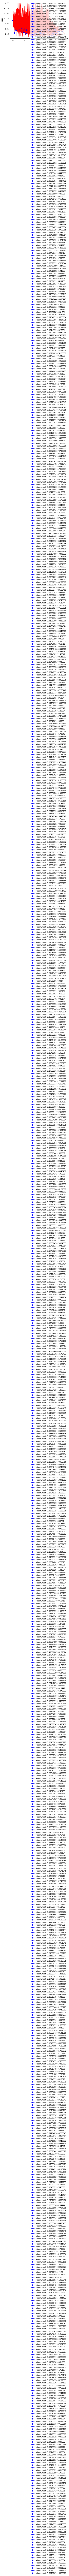

In [5]:
'''
Testing on manually chosen derandomized terms. For H2, ZXZX and ZZZZ alsone should do the job. 
These 2 terms cover the entire Hamiltonian. 
'''

def objective_function(operators, params):
    
    pauli_op_dict = Counter(tuple(x) for x in operators)
    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        qc = ansatz.bind_parameters(params)
        qc.compose(rand_meas_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values
                output_str = list(count)
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                shadow.append(snapshot)
                
    
    cost = 0.0
    for term, weight in zip(hamiltonian_terms_XYZ, weights):
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = sum_product / match_count
            cost = cost + (weight * exp_val)
            
        
    cost_history.append(cost)

        
    return cost




statistics = []
ZXZX, ZZZZ = 0, 1000
for _ in range(1000):
    derandomized_hamiltonian = [['Z', 'X', 'Z', 'X']] * ZXZX + [['Z', 'Z', 'Z', 'Z']] * ZZZZ
    ZXZX += 1
    ZZZZ -= 1
    
    cost_function = partial(objective_function, derandomized_hamiltonian)


    start_time = time.time()
    optimizer = COBYLA(maxiter=1000)   
    expectation_values = []
    num_experiments = 2

    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history))    
        #print("GROUND STATE ENERGY FOUND = ", min(cost_history))

        if iteration == num_experiments-1:

            num_points = len(cost_history)

            min_energy = min(cost_history)
            min_energy_idx = cost_history.index(min_energy)
            minimum_str = str(min_energy)

            plt.plot([i for i in range(num_points)], [cost_history[i] for i in range(num_points)], 'r')
            plt.plot(min_energy_idx, min_energy, 'b', marker="o", markersize=7, label='Minimum at '+ minimum_str)
            plt.xlabel('iterations')
            plt.ylabel('cost')
            plt.legend(loc=1)


    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)
    
    statistics.append(([ZXZX, ZZZZ], rmse_derandomised_cs))
    
    print('ZXZX: {}, ZZZZ: {}, AVERAGE ERROR: {}'.format(ZXZX, ZZZZ, rmse_derandomised_cs))

elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [203]:
'''
Above we have assumed a particular ground state energy for the molecule of interest.
Below we corroborate this assumption using a classical minimum eigensolver on our Hamiltonian.
'''

converter = QubitConverter(BravyiKitaevMapper())
numpy_solver = NumPyMinimumEigensolver()   

calc = GroundStateEigensolver(converter, numpy_solver)
res = calc.solve(problem)
print('Electronic ground state energy:\n', res) 

Electronic ground state energy:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948701555]
    - computed part:      [0.0  0.0  1.388948701555]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000001555]  Total: 0.000000001555
                 (debye): [0.0  0.0  -0.000000003953]  Total: 0.000000003953
 
